<table width="50%"><tr>
<td> <img src="../../img/dipy_logo.png" align="left" alt="Drawing" style="width: 155px;"/> </td>
<td> <img src="../../img/gsoc_logo.png" align="right" alt="Drawing" style="width: 220px;"/> </td>
</tr></table>

**Student**\
David Romero-Bascones\
**Mentors**\
Bramsh Qamar Chandio\
Shreyas Fadnavis\
Jong Sung Park

# **Graph matching tests**

Test of the robustness of graph-matching to correctly match streamlines from a bundle after displacing it.

Based on the work by [Olivetti et al., 2016](https://doi.org/10.3389/fnins.2016.00554) and its [available implementation](https://github.com/emanuele/DSPFP).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from DSPFP import DSPFP_faster
from dipy.io.streamline import load_trk
from dipy.tracking.streamline import unlist_streamlines, relist_streamlines, set_number_of_points, select_random_set_of_streamlines, transform_streamlines
from dipy.tracking.distances import bundles_distances_mdf
from dipy.viz import actor, window

#### Load bundle and preprocess

In [29]:
in_dir = '/home/david/Dropbox (MGEP)/projects/GSoC-2021/data/PPMI_data'
bundle_name = 'AF_L'
sub1 = '3850'

file1 = f'{in_dir}/{sub1}/org_bundles/streamlines_moved_{bundle_name}__labels__recognized_orig.trk'
bundle1 = load_trk(file1, reference='same', bbox_valid_check=False).streamlines

n_point = 20
n_stream = 700
bundle1 = set_number_of_points(bundle1, n_point)
bundle1 = select_random_set_of_streamlines(bundle1, n_stream)

#### Move the original bundle

In [30]:
d_y = 50
d_z = 0
phi_y = np.deg2rad(50)
affine = np.array([[1, 0, 0, 0], [0, np.cos(phi_y), -np.sin(phi_y), d_y],
                   [0, np.sin(phi_y), np.cos(phi_y), d_z], [0, 0, 0, 1]])
bundle2 = transform_streamlines(bundle1, affine)

#### Match streamlines

In [31]:
# Adjacency matrixes
A = bundles_distances_mdf(bundle1, bundle1)
B = bundles_distances_mdf(bundle2, bundle2)

# Perform matching
verbose = False
X = DSPFP_faster(A, B, verbose=verbose)
P = (X == X.max(1)[:, None])

matched = np.where(P == True)

In [32]:
success = np.count_nonzero(matched[0]==matched[1])
success_rate = np.round(100*success/n_stream,1)
print(f"Correctly matched streamlines: {success}/{n_stream} ({success_rate} %)")

Correctly matched streamlines: 554/700 (79.1 %)


#### Visualization

0 s1-s2:69-69
1 s1-s2:72-72
2 s1-s2:83-83
3 s1-s2:12-12
4 s1-s2:19-19
5 s1-s2:99-99
6 s1-s2:3-3
7 s1-s2:33-33
8 s1-s2:2-2
9 s1-s2:43-43
10 s1-s2:90-19
11 s1-s2:63-63
12 s1-s2:93-93
13 s1-s2:20-20
14 s1-s2:75-75
15 s1-s2:78-44
16 s1-s2:92-92
17 s1-s2:71-71
18 s1-s2:34-34
19 s1-s2:63-63


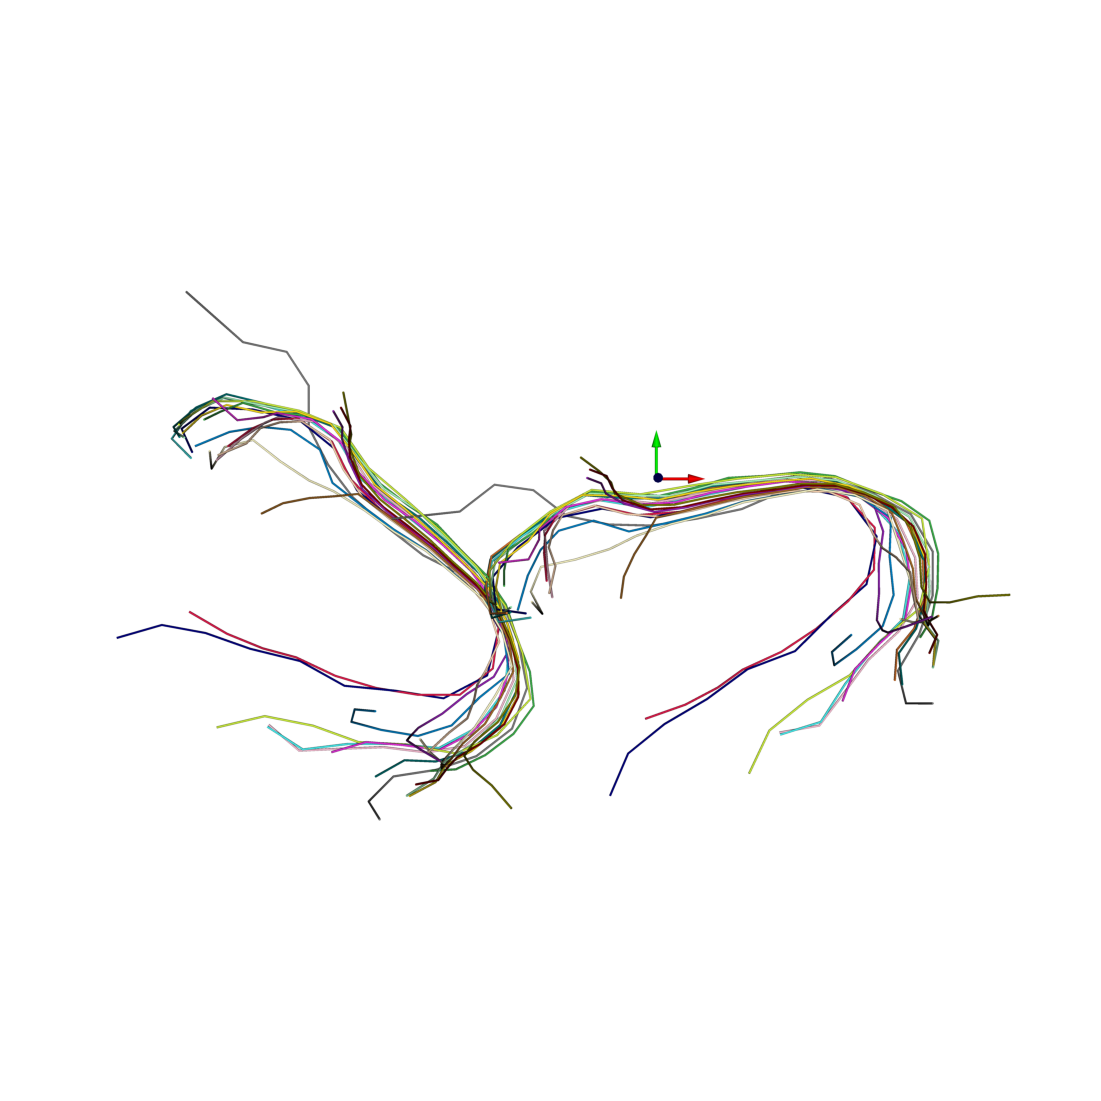

In [13]:
scene = window.Scene()
scene.SetBackground(1, 1, 1)

colors = [[230, 25, 75], [60, 180, 75], [255, 225, 25], [0, 130, 200],
          [245, 130, 48], [145, 30, 180], [70, 240, 240], [240, 50, 230],
          [210, 245, 60], [250, 190, 212], [0, 128, 128], [220, 190, 255],
          [170, 110, 40], [255, 250, 200], [128, 0, 0], [170, 255, 195],
          [128, 128, 0], [255, 215, 180], [0, 0, 128], [128, 128, 128],
          [255, 255, 255], [0, 0, 0]]
colors = np.array(colors)/255

# Pick few streamlines for visualization
ind_stream = np.random.choice(np.arange(n_stream), 20)

for i, ind in enumerate(ind_stream):
    s1 = bundle1[matched[0][ind]]
    s2 = bundle2[matched[1][ind]]

    print(f'{i:} s1-s2:{matched[0][ind]}-{matched[1][ind]}')
    
    # color = list(np.random.rand(1, 3))

    aux = s1.copy()
    lines_actor = actor.streamtube([aux], colors[i, :], linewidth=0.2)
    lines_actor.RotateX(-90)
    lines_actor.RotateZ(90)
    scene.add(lines_actor)

    lines_actor = actor.streamtube([s2], colors[i, :], linewidth=0.2)
    lines_actor.RotateX(-90)
    lines_actor.RotateZ(90)
    scene.add(lines_actor)

    axes_actor = actor.axes(scale=(10, 10, 10))
    scene.add(axes_actor)

img = window.snapshot(scene, size=(6000, 6000))
#window.show(scene)
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(img, origin='lower')
ax.axis('off')
plt.show()

The streamline matching is not perfect and decreases as the number of streamlines increases.